# Network Model

## I - Circuit Elements

We analyze the two circuit elements by computing their input-output response.

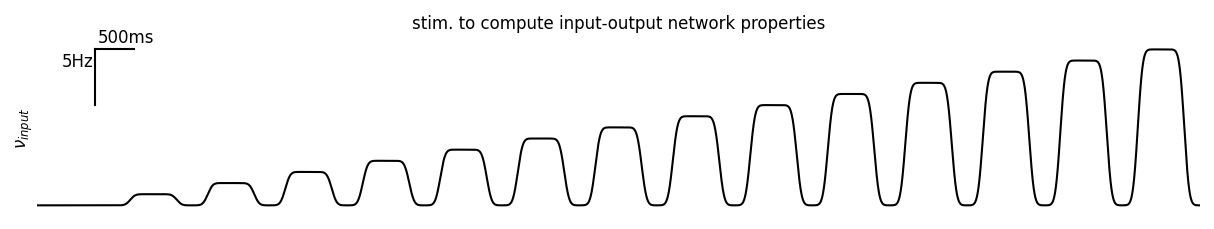

In [4]:
import plot_tools as pt
from src.InputOutput import *
fig, ax = plt.subplots(figsize=(10,1.5))
pt.plot(t, stim, ax=ax)
pt.set_plot(ax, spines=[], xlim=[0,t[-1]], title='stim. to compute input-output network properties', ylabel='$\\nu_{input}$')
pt.draw_bar_scales(ax, Xbar=500, Xbar_label='500ms', Ybar=5, Ybar_label='5Hz')

# quantify output resp at the different levels
def output_resp(rate,
                inter_frac=0.3):
    output = np.zeros(N)
    for e in range(N):
        t0 = e*episode+episode*inter_frac
        t1 = e*episode+episode*(1-inter_frac)
        output[e] = np.mean(rate[(t>t0) & (t<t1)])
    return output

### I-1) Disinhibitory Pathway

see Model properties in [./src/DsnhCircuit.py](./src/DsnhCircuit.py)

Run the simulation with:
```
python src/InputOutput.py Disinhibitory

```

In [15]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Dsnh.h5')

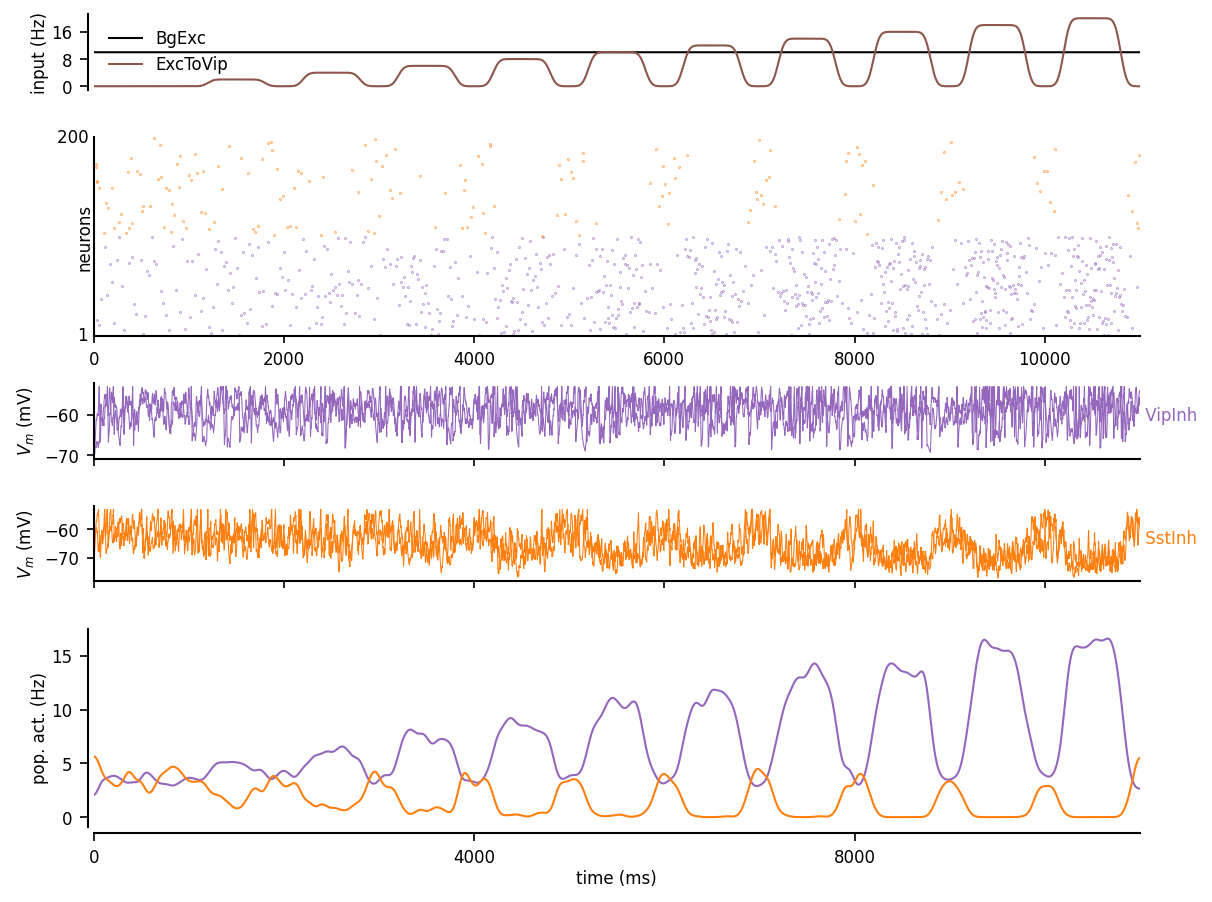

In [16]:
REC_POPS = ['VipInh', 'SstInh']
COLORS = ['tab:purple', 'tab:orange']
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

#### Multiple Runs

In [19]:
# RESTART THE KERNEL
from src.DsnhCircuit import *

Model['tstop'] = t[-1]+t[1]
for seed in range(10):
    NTWK = run_ntwk_sim(Model, REC_POPS,
                        AFF_POPS=AFF_POPS,
                        AFF_RATE_ARRAYS = [Model['F_BgExc']+0*t, 
                                           stim, stim],
                        SEED=seed,
                        verbose=False)

    ntwk.recording.write_as_hdf5(NTWK, filename='data/IO-Dsnh-%i.h5' % seed)

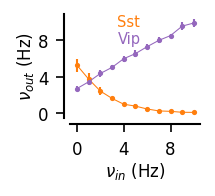

In [25]:
Resp = {'Sst':[], 'Vip':[]}
for seed in range(10):
    data = ntwk.recording.load_dict_from_hdf5('data/IO-Dsnh-%i.h5' % seed)
    for key in Resp:
        Resp[key].append(output_resp(data['POP_ACT_%sInh' % key]))
for key in Resp:
    Resp[key] = np.array(Resp[key])

fig, ax = pt.figure(figsize=(1.,1.1))
for i, label, color in zip(range(2),
                           ['Sst','Vip'],
                           ['tab:orange', 'tab:purple']):
    pt.scatter(Inputs[:11], Resp[label].mean(axis=0)[:11],
               sy = Resp[label].std(axis=0)[:11],
               color=color, lw=0.5, ms=1.5, ax=ax)
    ax.annotate(i*'\n'+label, (0.45,1), 
                va='top', ha='center',
                color=color,
                xycoords='axes fraction', fontsize=7)

pt.set_plot(ax, xlabel='$\\nu_{in}$ (Hz)',ylabel='$\\nu_{out}$ (Hz)')#, yscale='log')
fig.savefig('/Users/yann/Desktop/temp.svg')

## I-2) Recurrent Circuit

Run the simulation with:
```
python src/InputOutput.py Recurrent

```

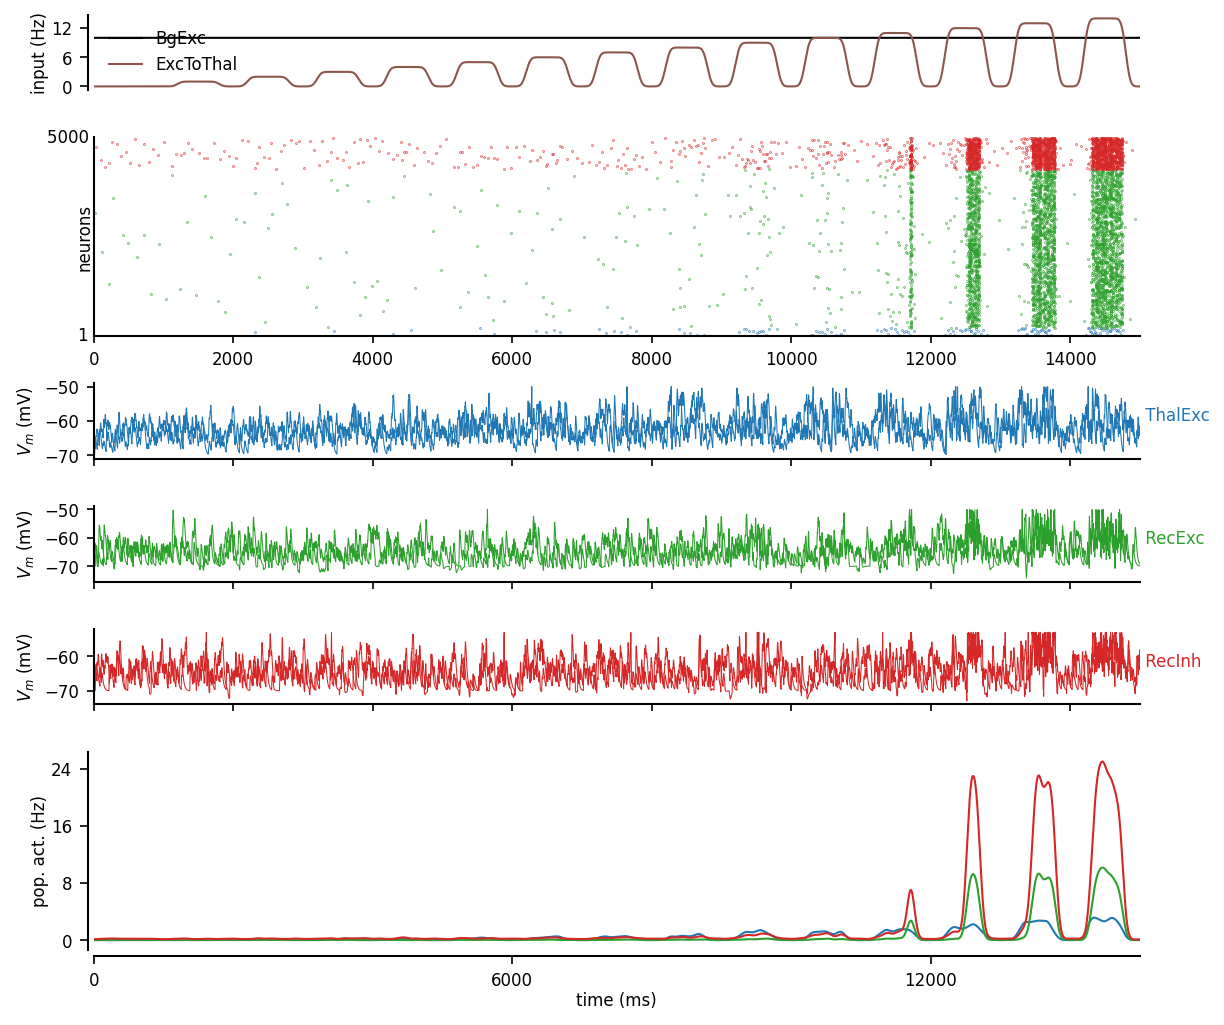

In [5]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Rec.h5')
from src.RecCircuit import *
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

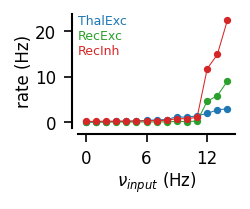

In [6]:
fig, ax = pt.figure(figsize=(1.1,1.2))
for i in range(len(REC_POPS)):
    ax.plot(Inputs, output_resp(data['POP_ACT_%s' % REC_POPS[i]]), 'o-', color=COLORS[i], lw=0.5)
    ax.annotate(i*'\n'+REC_POPS[i], (0.,1), va='top', color=COLORS[i], xycoords='axes fraction', fontsize=6)

pt.set_plot(ax, xlabel='$\\nu_{input}$ (Hz)', ylabel='rate (Hz)')#, yscale='log')

### Multiple Runs

In [7]:
# RESTART THE KERNEL
from src.RecCircuit import *

Model['tstop'] = t[-1]+t[1]
for seed in range(10):
    NTWK = run_ntwk_sim(Model, REC_POPS,
                        AFF_POPS=AFF_POPS,
                        AFF_RATE_ARRAYS = [Model['F_BgExc']+0*t, 
                                           stim, stim],
                        SEED=seed,
                        verbose=False)

    ntwk.recording.write_as_hdf5(NTWK, filename='data/IO-Dsnh-%i.h5' % seed)

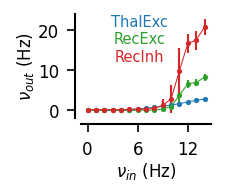

In [12]:
Resp = {'ThalExc':[], 'RecExc':[], 'RecInh':[]}
for seed in range(10):
    data = ntwk.recording.load_dict_from_hdf5('data/IO-Dsnh-%i.h5' % seed)
    for key in Resp:
        Resp[key].append(output_resp(data['POP_ACT_%s' % key]))
for key in Resp:
    Resp[key] = np.array(Resp[key])

fig, ax = pt.figure(figsize=(1.,1.1))
for i, label, color in zip(range(3),
                           list(Resp.keys()),
                           COLORS):
    pt.scatter(Inputs, Resp[label].mean(axis=0),
               sy = Resp[label].std(axis=0),
               color=color, lw=0.5, ms=1.5, ax=ax)
    ax.annotate(i*'\n'+label, (0.45,1), 
                va='top', ha='center',
                color=color,
                xycoords='axes fraction', fontsize=7)

pt.set_plot(ax, xlabel='$\\nu_{in}$ (Hz)',
            ylabel='$\\nu_{out}$ (Hz)')
fig.savefig('/Users/yann/Desktop/temp.svg')

## II - Coupling the Two Circuit Elements

Run:
```
python src/InputOutput.py Both-Coupled
```

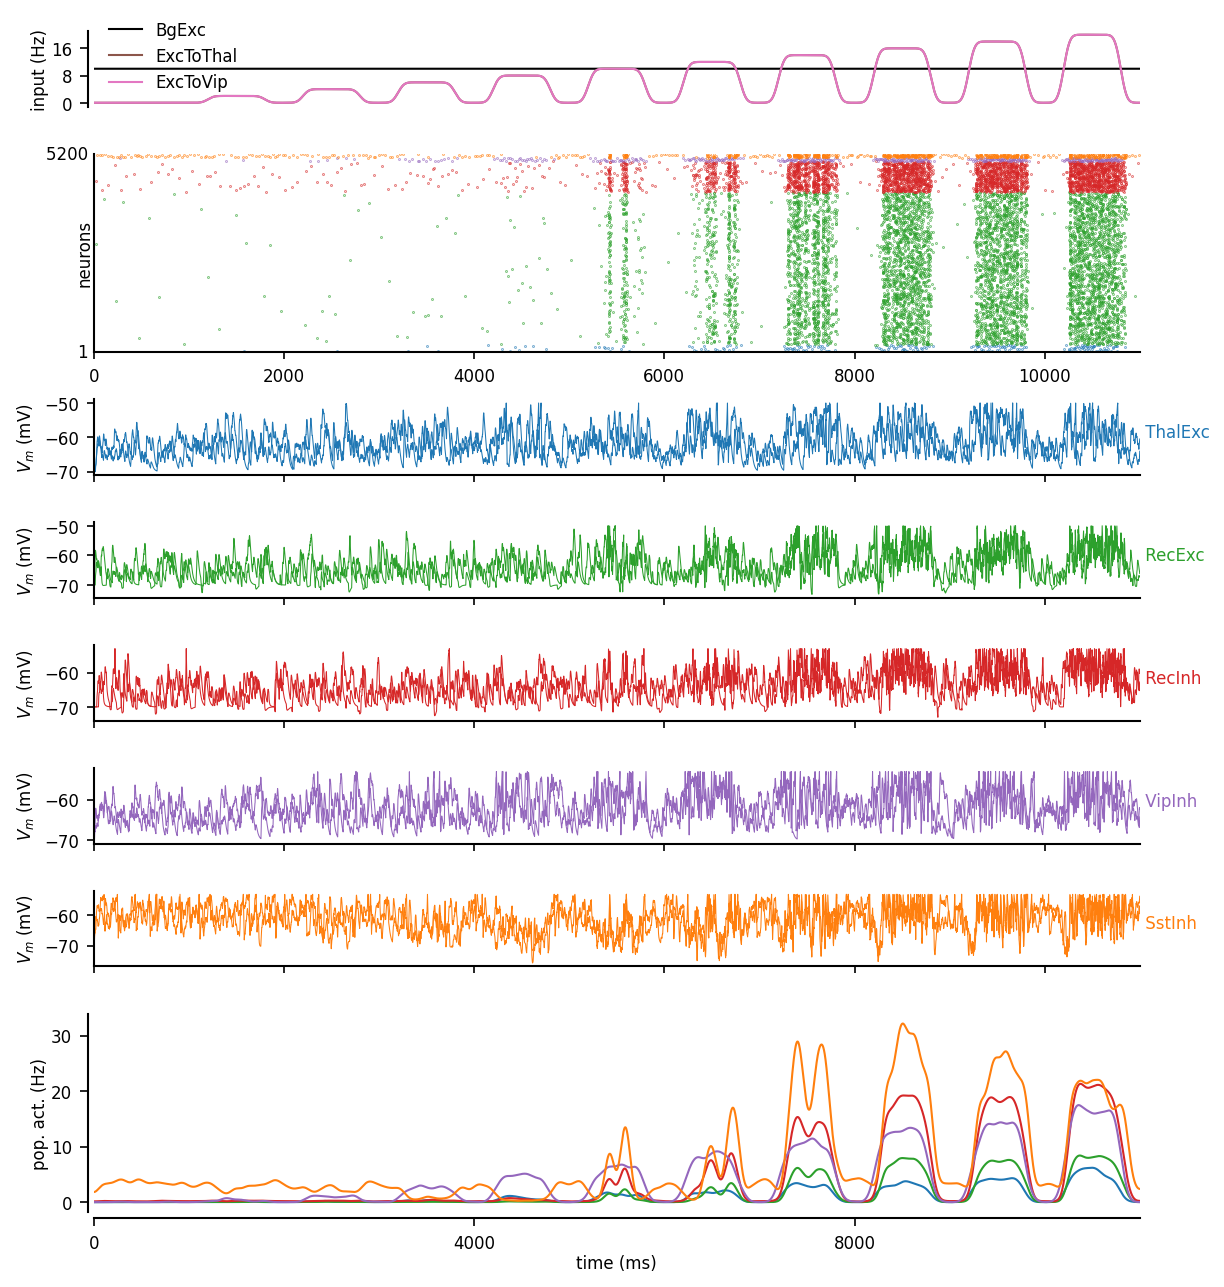

In [6]:
from neural_network_dynamics import ntwk
data = ntwk.recording.load_dict_from_hdf5('data/IO-Both-Coupled.h5')
from src.CoupledCircuit import *
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

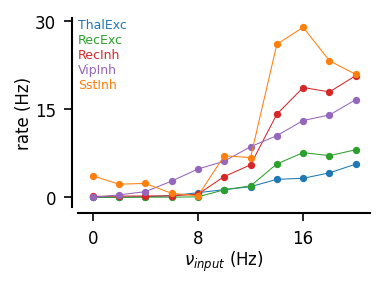

In [9]:
fig, ax = pt.figure(figsize=(1.5,2))
for i in range(len(REC_POPS)):
    ax.plot(Inputs, output_resp(data['POP_ACT_%s' % REC_POPS[i]]), 'o-', color=COLORS[i], lw=0.5)
    ax.annotate(i*'\n'+REC_POPS[i], (0.,1), va='top', color=COLORS[i], xycoords='axes fraction', fontsize=6)

pt.set_plot(ax, xlabel='$\\nu_{input}$ (Hz)', ylabel='rate (Hz)')#, yscale='log')

### Multiple runs

In [2]:
# RESTART THE KERNEL
from src.InputOutput import *
from src.CoupledCircuit import *

Model['tstop'] = t[-1]+t[1]
for seed in range(10):
    NTWK = run_ntwk_sim(Model, REC_POPS,
                        AFF_POPS=AFF_POPS,
                        AFF_RATE_ARRAYS = [Model['F_BgExc']+0*t, 
                                           stim, stim],
                        SEED=seed,
                        verbose=False)

    ntwk.recording.write_as_hdf5(NTWK, filename='data/IO-Dsnh-%i.h5' % seed)

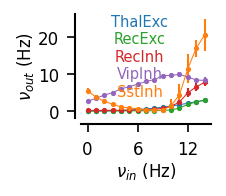

In [8]:
Resp = {'ThalExc':[], 'RecExc':[], 'RecInh':[], 'VipInh':[], 'SstInh':[]}
for seed in range(10):
    data = ntwk.recording.load_dict_from_hdf5('data/IO-Dsnh-%i.h5' % seed)
    for key in Resp:
        Resp[key].append(output_resp(data['POP_ACT_%s' % key]))
for key in Resp:
    Resp[key] = np.array(Resp[key])

fig, ax = pt.figure(figsize=(1.,1.1))
for i, label, color in zip(range(5),
                           list(Resp.keys()),
                           COLORS):
    pt.scatter(Inputs, Resp[label].mean(axis=0),
               sy = Resp[label].std(axis=0),
               color=color, lw=0.5, ms=1.5, ax=ax)
    ax.annotate(i*'\n'+label, (0.45,1), 
                va='top', ha='center',
                color=color,
                xycoords='axes fraction', fontsize=7)

pt.set_plot(ax, xlabel='$\\nu_{in}$ (Hz)',
            ylabel='$\\nu_{out}$ (Hz)')
fig.savefig('/Users/yann/Desktop/temp.svg')